# Results
#### Dedicated purely to the most interesting results. Comprehensive overview of my findings and inferences
For a full breakdown of my thought & analysis process, visit `exploration.ipynb`

In [1]:
from data.render import DataRenderer
from data.load import DataLoader
from data.api import SpotifyAPI

In [2]:
api = SpotifyAPI()
loader = DataLoader()
renderer = DataRenderer()

df_aoty = loader.load_aoty()
df_top100s = loader.load_top100s()

---

## ~ Notable characteristics on the Spotify Top 100, and how to make a chart-topper
*The Spotify Top 100 is an ordered ranking of the top 100 most streamed songs ever on Spotify*

### 1. Energy
Spotify defines energy as the single-value representation of a song's "dynamic range, perceived loudness, timbre, onset rate, and general entropy" *(2)*

Initial hypothesis: High-energy tracks perform typically perform better than its low-energy counterparts, so we will see a larger proportion of the Spotify Top 100 occupied by songs with a higher energy metric ($\geq 50$)

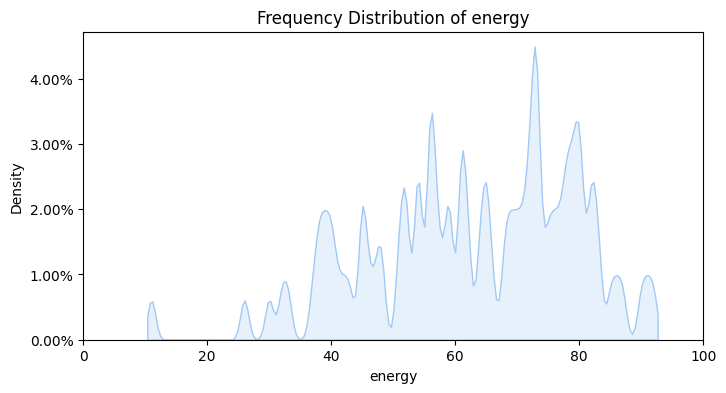

In [3]:
renderer.plot_density(df_top100s, 'energy')

In [4]:
energy = loader.get_col(df_top100s, 'energy')
str(energy.mean()), str(energy.median()), str(energy.std())

('62.68', '64.5', '16.491736528861168')

Results: Most of the Spotify Top 100 consists of high energy music. Because we don't have access to Spotify's specific metric calculations, we can either assume that the energy metric is generally overcalculated or our original hypothesis was correct. We expand on this idea in the next section.

### 2. BPM (Beats per Minute)
*Beats per minute is the number of 'beats' in a song that pass every minute. It's a measure of tempo and a higher bpm generally indicates a faster song (with some exceptions, which I will cover in the results). Note that Spotify makes this calculation; this metadata is typically NOT provided by the artist*

Initial hypothesis: Because energy is generally high, I expect a high average BPM because faster songs are generally correlated with energy (although keep in mind that Spotify factors in several components to its energy metric, and tempo is not explicitly labeled as one of them. However, a song with higher tempo may suggest that it has more or less dynamic range, for example).

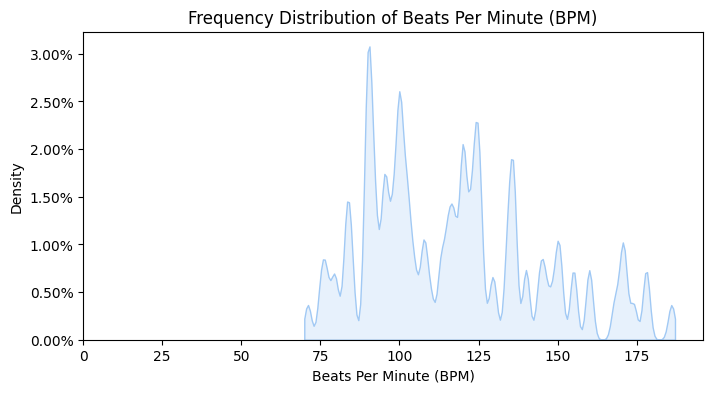

In [5]:
# scaled=False because BPM does not range absolutely from 0 to 100, so the graph observes all BPMs in the Spotify Top 100
renderer.plot_density(df_top100s, 'beats.per.minute', "Beats Per Minute (BPM)", scaled=False)

In [6]:
bpm = loader.get_col(df_top100s, 'beats.per.minute')
str(bpm.mean()), str(bpm.median()), str(bpm.std())

('116.97', '115.0', '27.470628943390697')

Results: Most of the BPM ranges between 90 and 143 BPM. Compared to songs not on the Top 100, this is normal speed and nothing unordinary. We can interpret this in a few ways: the energy metric might be overcalculated, tempo might not have as much of an influence on the energy metric as expected, or some values are being misrepresented.

To expand on the idea of 'misrepresented' BPMs, recall that Spotify makes this calculation. Therefore, because we don't have information on how Spotify calculates BPM, it is a **very real possibility** that some BPMs are being represented in half-time or double-time: that is, a song in 160 BPM can be 80 BPM per Spotify's algorithm, or vice versa *(4)*

With all things considered, at the moment we can only say that (according to Spotify) high energy tracks tend to chart higher, but BPM does not necessarily matter for this metric. Most Top 100 entries sit around 100 BPM, but this may be by coincidence considering this is a popular BPM range for most songs, not just chart-toppers.